<a href="https://colab.research.google.com/github/abyaadrafid/Deep-Reinforcement-Learning/blob/master/Policy%20Gradients/Discrete_Actor_Critic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Value Actor Critic for Discrete Action Space

# <font color='red'>Please Run the Notebook on CPU.</font>
There is something broken with the GPU setting in the code. I'll probably fix it sometime soon.



In [1]:
!apt install swig cmake libopenmpi-dev zlib1g-dev
!pip install stable-baselines[mpi]==2.10.0 box2d box2d-kengz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
zlib1g-dev is already the newest version (1:1.2.11.dfsg-0ubuntu2).
libopenmpi-dev is already the newest version (2.1.1-8).
swig is already the newest version (3.0.12-1).
cmake is already the newest version (3.10.2-1ubuntu2.18.04.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
import numpy as np
import pandas as pd
import gym
import matplotlib.pyplot as plt
from torch.distributions import Categorical
%matplotlib inline

plt.style.use('seaborn')

In [3]:
env = gym.make('LunarLander-v2')
env.seed(0)
print(env.action_space)
print(env.observation_space)

Discrete(4)
Box(8,)


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
class ActorCritic(nn.Module):
  def __init__(self, state_size, action_size, fc1_size = 128, fc2_size = 256):
    super(ActorCritic, self).__init__()

    self.stem = nn.Sequential(
        nn.Linear(state_size, fc1_size),
        nn.ReLU(),
        nn.Linear(fc1_size, fc2_size),
        nn.ReLU()
    )

    self.actor = nn.Sequential(
        self.stem,
        nn.Linear(fc2_size, action_size),
        nn.Softmax()
    )
    
    self.critic = nn.Sequential(
        self.stem,
        nn.Linear(fc2_size, 1),
    )

  def forward(self, x):
    value = self.critic(x)
    probabilities = self.actor(x)
    dist = Categorical(probabilities)

    return dist, value

In [16]:
class DiscreteACAgent():
  def __init__(self, lr, state_size, action_size, fc1_size = 128, fc2_size = 256, gamma= 0.99):
    self.gamma = gamma
    self.actor_critic = ActorCritic(state_size, action_size, fc1_size, fc2_size).to(device)
    self.optimizer = optim.Adam(self.actor_critic.parameters(), lr)
    self.log_probs = None

  def choose_action(self, state):
    action_probs, _ = self.actor_critic.forward(state)
    action = action_probs.sample()
    self.log_probs = action_probs.log_prob(action)
    
    return action.item()

  def learn(self, state, reward, next_state, done):
    self.optimizer.zero_grad()

    _, value = self.actor_critic.forward(state)
    _, next_value = self.actor_critic.forward(next_state)

    delta = reward + self.gamma*next_value*(1-int(done)) - value

    actor_loss = -self.log_probs*delta
    critic_loss = delta**2

    loss = actor_loss+critic_loss
    loss.backward()

    self.optimizer.step()

In [17]:
state_size = env.observation_space.shape[0]
action_size = env.action_space.n

print('State size: {}, action size: {}'.format(state_size, action_size))

State size: 8, action size: 4


In [18]:
agent = DiscreteACAgent(1e-5, state_size=state_size, action_size=action_size)
n_episodes = 3000
gamma = 0.99
PRINT_EVERY = 50
ENV_SOLVED = 200

In [22]:
def train(agent):
  score_history = []
  print_score = []
  for i in range(n_episodes):
    done = False
    state = env.reset()
    score = 0
    while not done:
      state = torch.Tensor(state).to(device)
      action = agent.choose_action(state)
      next_state, reward, done, info = env.step(action)
      next_state = torch.Tensor(next_state).to(device)
      agent.learn(state, reward, next_state, done)
      state = next_state
      score += reward
    score_history.append(score)
    print_score.append(score)
    if i % PRINT_EVERY == 0 :
      print('\r Progress {}/{}, average score:{:.2f}'.format(i, n_episodes, np.mean(print_score)), end="")
      print_score = []
    if score == ENV_SOLVED :
      print('The Environment is solved')
  return score_history

In [23]:
def plot(score, string):
  plt.figure(figsize=(10,6))
  plt.plot(score)
  plt.plot(pd.Series(score).rolling(100).mean())
  plt.title('%s Training,'%string)
  plt.xlabel('# of episodes')
  plt.ylabel('score')
  plt.show()

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


 Progress 2950/3000, average score:-107.53

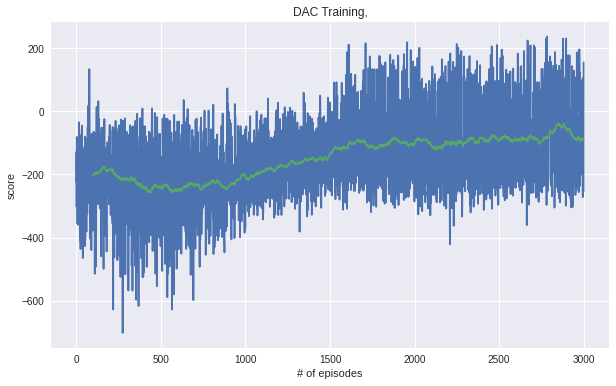

In [24]:
score = train(agent)
plot(score, 'DAC')

##### As we can see, the agent isn't actually that great. But slowly and surely it shows increase in performance on average. The Value actor critic can be quite unstable while training, as seen from the huge fluctuations of reward between episodes. It takes more episodes than all other methods we've covered so far, but it solves the environment by reaching 200 reward. 